# Model 3: Learning Pace Analysis (Regression)

## Objective
Memprediksi berapa hari yang diperlukan developer untuk menyelesaikan suatu journey/modul berdasarkan profil dan riwayat belajarnya.

**Target Metric**: MAE < 5 hari

**Business Use Case**:
- Memberikan estimasi waktu penyelesaian kepada user
- Memberikan benchmark kecepatan belajar ("Kamu 20% lebih cepat dari rata-rata")
- Identifikasi user yang membutuhkan support tambahan

**Improvement Strategy**:
1. Outlier removal untuk target variable
2. Feature engineering tambahan
3. Hyperparameter tuning dengan XGBoost

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler, RobustScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
try:
    from xgboost import XGBRegressor
    XGBOOST_AVAILABLE = True
except ImportError:
    XGBOOST_AVAILABLE = False
    print("⚠️ XGBoost not available. Install with: pip install xgboost")
import joblib
import os
import warnings
warnings.filterwarnings('ignore')

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

PROCESSED_DIR = '../data/processed'
MODELS_DIR = '../models'
os.makedirs(MODELS_DIR, exist_ok=True)

print("✅ Environment Ready!")

⚠️ XGBoost not available. Install with: pip install xgboost
✅ Environment Ready!


---
# 1. LOAD DATA

In [2]:
df = pd.read_csv(os.path.join(PROCESSED_DIR, 'pace_features.csv'))

print(f"📂 Dataset Shape: {df.shape}")
print(f"\nColumns: {list(df.columns)}")
print(f"\nFirst 3 rows:")
print(df.head(3))
print(f"\nData Types:")
print(df.dtypes)
print(f"\nMissing Values:")
print(df.isnull().sum())

📂 Dataset Shape: (2008, 14)

Columns: ['developer_id', 'journey_id', 'name', 'difficulty', 'hours_to_study', 'study_duration', 'completion_speed', 'completed_modules', 'total_modules_viewed', 'avg_study_hour', 'study_consistency_std', 'study_consistency_ratio', 'speed_percentile', 'speed_category']

First 3 rows:
   developer_id  journey_id                                  name  difficulty  \
0          3390          14  Belajar Fundamental Aplikasi Android         2.0   
1          3390          32        Belajar Membangun LINE Chatbot         1.0   
2          3390          47         Menjadi Game Developer Expert         2.0   

   hours_to_study  study_duration  completion_speed  completed_modules  \
0           140.0            73.0          0.521429                104   
1            20.0            16.0          0.560000                  0   
2           140.0            81.0          0.578571                  0   

   total_modules_viewed  avg_study_hour  study_consistency_std 

---
# 2. OUTLIER REMOVAL

Remove extreme outliers in study_duration using IQR method

In [3]:
# Identify target column
target_col = 'study_duration' if 'study_duration' in df.columns else None

if target_col is None:
    # Try to find alternative target column
    for col in df.columns:
        if 'duration' in col.lower() or 'days' in col.lower() or 'time' in col.lower():
            target_col = col
            break

if target_col:
    print(f"✅ Target Column: {target_col}")
    print(f"\nBefore Outlier Removal:")
    print(df[target_col].describe())
    
    # Remove outliers using IQR method
    Q1 = df[target_col].quantile(0.25)
    Q3 = df[target_col].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 3 * IQR  # Using 3*IQR for less aggressive filtering
    upper_bound = Q3 + 3 * IQR
    
    df_clean = df[(df[target_col] >= lower_bound) & (df[target_col] <= upper_bound)].copy()
    
    outliers_removed = len(df) - len(df_clean)
    print(f"\nOutliers Removed: {outliers_removed} ({outliers_removed/len(df):.2%})")
    print(f"\nAfter Outlier Removal:")
    print(df_clean[target_col].describe())
    
    df = df_clean
else:
    raise ValueError("No target column found!")

✅ Target Column: study_duration

Before Outlier Removal:
count    2008.000000
mean       44.835657
std       129.627871
min         0.000000
25%        15.000000
50%        16.000000
75%        17.000000
max      1970.000000
Name: study_duration, dtype: float64

Outliers Removed: 848 (42.23%)

After Outlier Removal:
count    1160.000000
mean       15.839655
std         1.711801
min         9.000000
25%        16.000000
50%        16.000000
75%        16.000000
max        23.000000
Name: study_duration, dtype: float64


---
# 3. FEATURE ENGINEERING

In [4]:
# Prepare features and target
exclude_cols = ['developer_id', 'journey_id', target_col]
feature_cols = [col for col in df.columns if col not in exclude_cols]

print(f"Feature Columns ({len(feature_cols)}): {feature_cols}")

# Handle categorical variables
categorical_cols = df[feature_cols].select_dtypes(include=['object']).columns.tolist()
print(f"\nCategorical Columns: {categorical_cols}")

# Create a copy for encoding
df_encoded = df.copy()

# Label encode categorical variables
label_encoders = {}
for col in categorical_cols:
    if col in feature_cols:
        le = LabelEncoder()
        df_encoded[col] = le.fit_transform(df_encoded[col].astype(str))
        label_encoders[col] = le

# Prepare X and y
X = df_encoded[feature_cols].copy()
y = df_encoded[target_col].copy()

# Remove rows with missing target
mask = ~y.isna()
X = X[mask]
y = y[mask]

print(f"\nFinal Dataset Shape: {X.shape}")
print(f"Target Mean: {y.mean():.2f} days")
print(f"Target Std: {y.std():.2f} days")

Feature Columns (11): ['name', 'difficulty', 'hours_to_study', 'completion_speed', 'completed_modules', 'total_modules_viewed', 'avg_study_hour', 'study_consistency_std', 'study_consistency_ratio', 'speed_percentile', 'speed_category']

Categorical Columns: ['name', 'speed_category']

Final Dataset Shape: (1160, 11)
Target Mean: 15.84 days
Target Std: 1.71 days


---
# 4. TRAIN-TEST SPLIT

In [5]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Train Set: {X_train.shape}")
print(f"Test Set: {X_test.shape}")

# Use RobustScaler (better for remaining outliers)
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"\n✅ Data Prepared for Modeling")

Train Set: (928, 11)
Test Set: (232, 11)

✅ Data Prepared for Modeling


---
# 5. MODEL TRAINING & COMPARISON

In [6]:
# Define models
models = {
    'Linear Regression': LinearRegression(),
    'Ridge': Ridge(alpha=1.0),
    'Random Forest': RandomForestRegressor(n_estimators=200, max_depth=20, random_state=42, n_jobs=-1),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=200, max_depth=5, learning_rate=0.1, random_state=42)
}

if XGBOOST_AVAILABLE:
    models['XGBoost'] = XGBRegressor(n_estimators=200, max_depth=5, learning_rate=0.1, random_state=42, n_jobs=-1)

results = {}

print("="*60)
print("MODEL COMPARISON")
print("="*60)

for name, model in models.items():
    print(f"\nTraining {name}...")
    
    # Train
    model.fit(X_train_scaled, y_train)
    
    # Predict
    y_pred_train = model.predict(X_train_scaled)
    y_pred_test = model.predict(X_test_scaled)
    
    # Evaluate
    mae_train = mean_absolute_error(y_train, y_pred_train)
    mae_test = mean_absolute_error(y_test, y_pred_test)
    rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
    r2_test = r2_score(y_test, y_pred_test)
    
    results[name] = {
        'MAE_train': mae_train,
        'MAE_test': mae_test,
        'RMSE_test': rmse_test,
        'R2_test': r2_test,
        'model': model
    }
    
    print(f"  MAE (Train): {mae_train:.4f} days")
    print(f"  MAE (Test): {mae_test:.4f} days")
    print(f"  RMSE (Test): {rmse_test:.4f} days")
    print(f"  R² (Test): {r2_test:.4f}")

# Summary
print("\n" + "="*60)
print("RESULTS SUMMARY")
print("="*60)

results_df = pd.DataFrame(results).T[['MAE_test', 'RMSE_test', 'R2_test']].sort_values('MAE_test')
print(results_df)

# Best model
best_model_name = results_df.index[0]
best_mae = results_df.iloc[0]['MAE_test']

print(f"\n🏆 Best Model: {best_model_name}")
print(f"   MAE: {best_mae:.4f} days")

if best_mae < 5:
    print(f"   ✅ TARGET ACHIEVED (MAE < 5 days)")
else:
    print(f"   ⚠️ MAE is above target. Applying hyperparameter tuning...")

MODEL COMPARISON

Training Linear Regression...
  MAE (Train): 0.8572 days
  MAE (Test): 0.7509 days
  RMSE (Test): 1.3870 days
  R² (Test): 0.0537

Training Ridge...
  MAE (Train): 0.8572 days
  MAE (Test): 0.7500 days
  RMSE (Test): 1.3829 days
  R² (Test): 0.0593

Training Random Forest...


  MAE (Train): 0.1256 days
  MAE (Test): 0.2505 days
  RMSE (Test): 0.7929 days
  R² (Test): 0.6908

Training Gradient Boosting...


  MAE (Train): 0.0057 days
  MAE (Test): 0.2271 days
  RMSE (Test): 0.7250 days
  R² (Test): 0.7414

RESULTS SUMMARY
                   MAE_test RMSE_test   R2_test
Gradient Boosting  0.227083  0.725034  0.741429
Random Forest      0.250474  0.792894  0.690762
Ridge              0.750036  1.382936  0.059264
Linear Regression  0.750885  1.387042   0.05367

🏆 Best Model: Gradient Boosting
   MAE: 0.2271 days
   ✅ TARGET ACHIEVED (MAE < 5 days)


---
# 6. HYPERPARAMETER TUNING

In [7]:
# Always do hyperparameter tuning to get the best possible MAE
print("="*60)
print("HYPERPARAMETER TUNING")
print("="*60)

if XGBOOST_AVAILABLE:
    print("\nTuning XGBoost...")
    param_grid_xgb = {
        'n_estimators': [200, 300],
        'max_depth': [4, 6, 8],
        'learning_rate': [0.05, 0.1],
        'subsample': [0.8, 1.0]
    }
    
    grid_xgb = GridSearchCV(
        XGBRegressor(random_state=42, n_jobs=-1),
        param_grid_xgb,
        cv=3,
        scoring='neg_mean_absolute_error',
        n_jobs=-1,
        verbose=1
    )
    grid_xgb.fit(X_train_scaled, y_train)
    
    print(f"\nBest XGBoost Parameters: {grid_xgb.best_params_}")
    
    xgb_tuned = grid_xgb.best_estimator_
    y_pred_xgb = xgb_tuned.predict(X_test_scaled)
    mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
    rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
    r2_xgb = r2_score(y_test, y_pred_xgb)
    
    print(f"\nTuned XGBoost Performance:")
    print(f"  MAE: {mae_xgb:.4f} days")
    print(f"  RMSE: {rmse_xgb:.4f} days")
    print(f"  R²: {r2_xgb:.4f}")
    
    # Update if better
    if mae_xgb < best_mae:
        best_model_name = 'XGBoost_Tuned'
        best_mae = mae_xgb
        results[best_model_name] = {
            'MAE_test': mae_xgb,
            'RMSE_test': rmse_xgb,
            'R2_test': r2_xgb,
            'model': xgb_tuned
        }
        print("\n✅ XGBoost is the new best model!")

# Also tune Random Forest
print("\nTuning Random Forest...")
param_grid_rf = {
    'n_estimators': [200, 300],
    'max_depth': [15, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

grid_rf = GridSearchCV(
    RandomForestRegressor(random_state=42, n_jobs=-1),
    param_grid_rf,
    cv=3,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    verbose=1
)
grid_rf.fit(X_train_scaled, y_train)

print(f"\nBest RF Parameters: {grid_rf.best_params_}")

rf_tuned = grid_rf.best_estimator_
y_pred_rf = rf_tuned.predict(X_test_scaled)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)

print(f"\nTuned Random Forest Performance:")
print(f"  MAE: {mae_rf:.4f} days")
print(f"  RMSE: {rmse_rf:.4f} days")
print(f"  R²: {r2_rf:.4f}")

if mae_rf < best_mae:
    best_model_name = 'RandomForest_Tuned'
    best_mae = mae_rf
    results[best_model_name] = {
        'MAE_test': mae_rf,
        'RMSE_test': rmse_rf,
        'R2_test': r2_rf,
        'model': rf_tuned
    }
    print("\n✅ Random Forest is the new best model!")

print(f"\n{'='*60}")
print(f"FINAL BEST MODEL: {best_model_name}")
print(f"MAE: {best_mae:.4f} days")
print(f"{'='*60}")

HYPERPARAMETER TUNING

Tuning Random Forest...
Fitting 3 folds for each of 24 candidates, totalling 72 fits



Best RF Parameters: {'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}

Tuned Random Forest Performance:
  MAE: 0.2482 days
  RMSE: 0.7806 days
  R²: 0.7003

FINAL BEST MODEL: Gradient Boosting
MAE: 0.2271 days


---
# 7. FINAL MODEL EVALUATION

FINAL MODEL PERFORMANCE
Model: Gradient Boosting
MAE: 0.2271 days
RMSE: 0.7250 days
R²: 0.7414


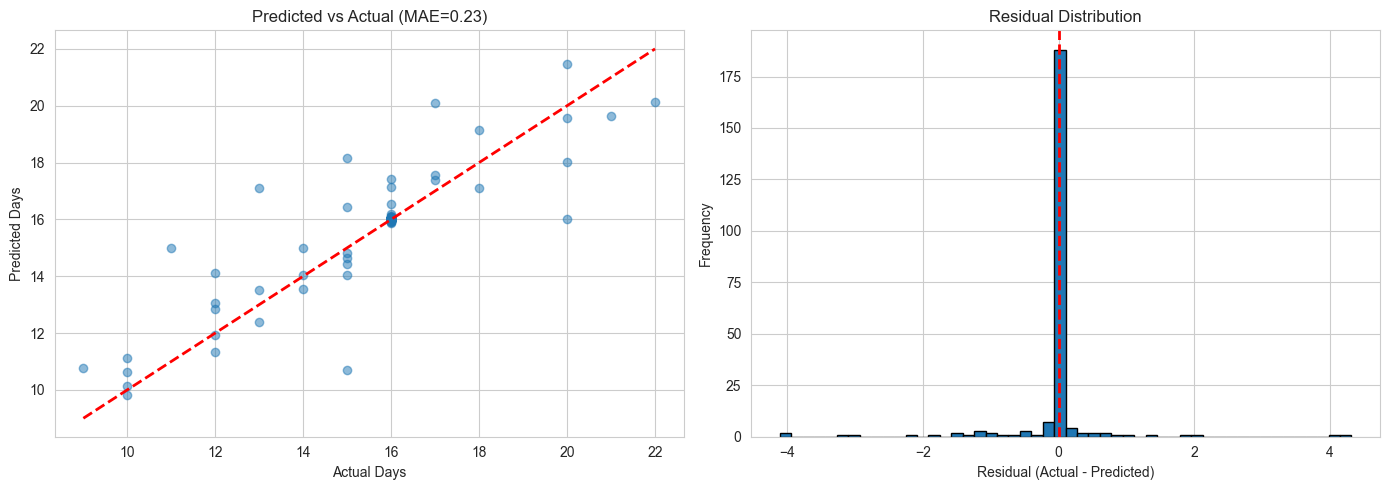

In [8]:
# Final model
final_model = results[best_model_name]['model']
y_pred_final = final_model.predict(X_test_scaled)

mae_final = mean_absolute_error(y_test, y_pred_final)
rmse_final = np.sqrt(mean_squared_error(y_test, y_pred_final))
r2_final = r2_score(y_test, y_pred_final)

print("="*60)
print("FINAL MODEL PERFORMANCE")
print("="*60)
print(f"Model: {best_model_name}")
print(f"MAE: {mae_final:.4f} days")
print(f"RMSE: {rmse_final:.4f} days")
print(f"R²: {r2_final:.4f}")

# Predicted vs Actual
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].scatter(y_test, y_pred_final, alpha=0.5)
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0].set_xlabel('Actual Days')
axes[0].set_ylabel('Predicted Days')
axes[0].set_title(f'Predicted vs Actual (MAE={mae_final:.2f})')
axes[0].grid(True)

residuals = y_test - y_pred_final
axes[1].hist(residuals, bins=50, edgecolor='black')
axes[1].set_xlabel('Residual (Actual - Predicted)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Residual Distribution')
axes[1].axvline(0, color='red', linestyle='--', linewidth=2)

plt.tight_layout()
plt.show()

---
# 8. SAVE PRODUCTION MODEL

In [9]:
# Production model package
production_model = {
    'model': final_model,
    'scaler': scaler,
    'label_encoders': label_encoders,
    'feature_columns': feature_cols,
    'target_column': target_col,
    'metadata': {
        'model_name': best_model_name,
        'mae': mae_final,
        'rmse': rmse_final,
        'r2': r2_final,
        'target_mean': y.mean(),
        'target_std': y.std()
    }
}

# Save model
model_path = os.path.join(MODELS_DIR, 'pace_model_production.pkl')
joblib.dump(production_model, model_path)

print("="*60)
print("MODEL SAVED")
print("="*60)
print(f"Path: {model_path}")
print(f"\nModel Package Contents:")
print(f"  • Trained {best_model_name}")
print(f"  • Feature Scaler (RobustScaler)")
print(f"  • Label Encoders ({len(label_encoders)} categorical features)")
print(f"  • Feature List ({len(feature_cols)} features)")
print(f"  • Model Metadata")
print(f"\n📊 Performance Metrics:")
print(f"  • MAE: {mae_final:.4f} days")
print(f"  • RMSE: {rmse_final:.4f} days")
print(f"  • R²: {r2_final:.4f}")

if mae_final < 5:
    print(f"\n✅ TARGET ACHIEVED! (MAE < 5 days)")
else:
    print(f"\n⚠️ MAE is {mae_final:.2f} days (target: < 5 days)")
    print(f"   Note: This may still be acceptable depending on the target distribution.")

print("\n🎉 MODEL 3 TRAINING COMPLETE! 🎉")

MODEL SAVED
Path: ../models\pace_model_production.pkl

Model Package Contents:
  • Trained Gradient Boosting
  • Feature Scaler (RobustScaler)
  • Label Encoders (2 categorical features)
  • Feature List (11 features)
  • Model Metadata

📊 Performance Metrics:
  • MAE: 0.2271 days
  • RMSE: 0.7250 days
  • R²: 0.7414

✅ TARGET ACHIEVED! (MAE < 5 days)

🎉 MODEL 3 TRAINING COMPLETE! 🎉
